In [1]:
# añadimos las librerías clásicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lec3_graphs as gfx

# importamos los módulos de sklearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# añadimos seaborn
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (10, 6)


Con nuestro ambiente de trabajo ya listo, vamos a importar ucbaddmissions.csv con
read_csv y nos aseguraremos de eliminar la columna Unnamed: 0 que se genera de forma
automática.

In [2]:
df = pd.read_csv('Datasets/ucbadmissions.csv').drop(columns='Unnamed: 0')
df.head()


,Admit,Gender,Dept,Freq
0,Admitted,Male,A,512
1,Rejected,Male,A,313
2,Admitted,Female,A,89
3,Rejected,Female,A,19
4,Admitted,Male,B,353


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Admit   24 non-null     object
 1   Gender  24 non-null     object
 2   Dept    24 non-null     object
 3   Freq    24 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 896.0+ bytes


Como primer paso exploratorio, veamos cuál es la distribución de cada atributo en nuestra
base. Un problema que encontraremos es que nuestro DataFrame es una tabla procesada
que muestra la frecuencia de la combinación de valores en 'Admit', 'Gender' y 'Dept'.
Esto nos generará problemas posteriormente cuando queramos implementar nuestro
modelo, dado la baja cantidad de datos.

Nuestra estrategia es aumentar artificialmente cada combinación de valores dada la
frecuencia.

Para ello implementaremos una función que tome como argumento de ingreso la tabla
agregada, y devuelva la cantidad de observaciones correctas mediante
deaggregate_statistics.

In [4]:
# dado lo verboso de la función, ésta se encuentra en el archivo auxiliar
df_deagg = gfx.deaggregate_statistics(df)
df_deagg.shape


(4526, 3)

Antes de seguir con nuestro análisis, debemos procurar que nuestra base desagregada
represente la suma de df['Freq']. Esto lo logramos con una operación booleana simple. El
resultado nos confiere que el procedimiento está bien hecho. Con nuestra base procesada,
realizamos una serie de gráficos de barras por cada elemento.

In [5]:
# devuelve un booleano que compare la cantidad de observaciones en ambas bases
df_deagg.shape[0] == sum(df['Freq'])


True

Ahora podemos graficar:

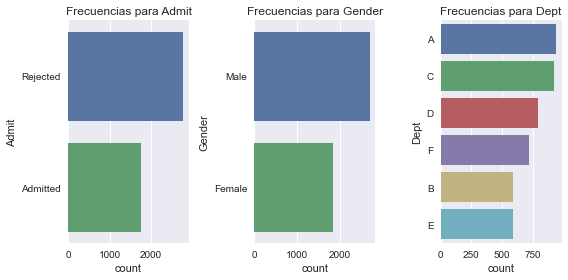

In [6]:
# definimos un canvas con tamaños fijos para mejorar la presentación
plt.figure(figsize=(8, 4))
# para cada elemento de nuestra columna, devuelve un número (n) y el elemento (i)
for n, i in enumerate(['Admit', 'Gender', 'Dept']):
    # generamos tres subplots en una fila
    # generamos un contador de frecuencia con seaborn
    # ordenamos las frecuencias de mayor a menor
    plt.subplot(1, 3, n + 1)
    sns.countplot(y= df_deagg[i], order = df_deagg[i].value_counts().index)
    # agregamos el título
    plt.title('Frecuencias para {}'.format(i))
    # mejoramos los márgenes
    plt.tight_layout()

UC Berkeley es una universidad pública de élite, por lo que las tasas de rechazo no resultan
sorprendentes. Aproximadamente el 61% de los postulantes fueron rechazados. La mayoría
de los postulantes fueron a los departamentos A y C (ambos con un 20%), pero en general la
postulación fue homogénea. La mayoría de los postulantes fueron hombres (cercano al
60%) y el restante fueron mujeres.

In [7]:
for _ , i in df_deagg.iteritems():
    print(i.value_counts('%'),"\n")

Rejected    0.61224
Admitted    0.38776
Name: Admit, dtype: float64 

Male      0.594565
Female    0.405435
Name: Gender, dtype: float64 

A    0.206142
C    0.202828
D    0.174989
F    0.157755
B    0.129253
E    0.129032
Name: Dept, dtype: float64 



In [8]:
df_deagg['Dept'].unique()

array(['A', 'B', 'C', 'D', 'E', 'F'], dtype=object)

### Implementado un algoritmo Naive Bayes
Para implementar el modelo, utilizaremos la clase BernoulliNB dentro del módulo
linear_model de la librería sklearn. Como el algoritmo NB es un problema de clasificación
supervisada dado que tenemos conocimiento sobre la cantidad de clases y en un espacio
finito 𝑌 debemos importar de manera adicional las métricas de desempeño más comunes
como roc_auc_score, roc_curve, confusion_matrix.

Considerando que todos los registros en la base desagregada son strings, debemos
transformar estos atributos categóricos a numéricos para facilitarle el trabajo a Sklearn.
Para ello implementaremos la clase LabelEncoder que se encuentra en el módulo
preprocessing de sklearn. Nuestro primer paso es convertir los atributos. LabelEncoder
genera un encoding entre 0 y la cantidad de clases -1. Para generar nuestra recodificación,
posterior a la inicialización de la clase LabelEncoder implementamos el método
fit_transform que devuelve las etiquetas numéricas. El modelo que implementaremos
sólo admite variables binarias, por lo que implementaremos el método pd.get_dummies
para extraer una serie de binarias por cada categoría de departamentos.


In [9]:
# instanciamos el objeto
lbl = LabelEncoder()

In [10]:
# Implementamos el método fit_transform para actualizar y sobreescribir cada columna de atributos
df_deagg['Gender'] = lbl.fit_transform(df_deagg['Gender'])
df_deagg['Admit'] = lbl.fit_transform(df_deagg['Admit'])

# generamos una serie de dummies en base a Dept y las concatenamos a nuestra base.
# posteriormente, eliminamos la columna Dept
df_deagg = pd.concat([df_deagg, pd.get_dummies(df_deagg['Dept'], prefix = 'dept')], axis = 1).drop(columns = 'Dept')

In [11]:
# solicitemos las últimas 5 observaciones de nuestra base
df_deagg.tail()

,Admit,Gender,dept_A,dept_B,dept_C,dept_D,dept_E,dept_F
4521,1,0,0,0,0,0,0,1
4522,1,0,0,0,0,0,0,1
4523,1,0,0,0,0,0,0,1
4524,1,0,0,0,0,0,0,1
4525,1,0,0,0,0,0,0,1


In [12]:
# Verifiquemos que la variable Admit esta lista para ser procesada por el clasificador
df_deagg['Admit'].value_counts('%')

1    0.61224
0    0.38776
Name: Admit, dtype: float64

Posterior a la reconversión de los valores, seguimos con nuestro flujo básico de trabajo
generando muestras de entrenamiento y validación con train_test_split, dejando un
30% de la muestra como validación y declarando una semilla pseudoaleatoria.

In [13]:
X_train_mat, X_test_mat, y_train_vec, y_test_vec = train_test_split(df_deagg.loc[:, 'Gender':'dept_F'], df_deagg['Admit'],
                                                                    test_size=.30, random_state=15820)
X_train_mat.shape

(3168, 7)

In [14]:
X_test_mat.shape[0] / df_deagg.shape[0]

0.30004418912947417

#### El clasificador BernoulliNB()
Siguiendo el flujo de trabajo, lo que debemos hacer es generar una instancia del Clasificador.
La documentación de BernoulliNB() hace referencia a 4 hiper parámetros a considerar:
1. alpha: Añade un parámetro aditivo a la probabilidad 𝑃𝑟(𝑋 . Esta adición permite
𝑘
|𝑦)
superar el problema del floating point underflow cuando nos encontramos con
probabilidades 𝑃𝑟(𝑋 . Cuando alpha=1, se llama suavización de Laplace y
𝑘
|𝑦) = 0
cuando alpha es un decimal entre 0 y 1 se conoce como suavización de Lidstone.
2. binarize: Implementado cuando los atributos son continuos y se necesita declarar
un umbral para la binarización.
3. fit_prior: Por defecto calcula la probabilidad a priori de cada clase en la muestra
de entrenamiento. Si es False, asume una distribución uniforme en base a 1/𝑁
𝑦∈𝑌
.
4. class_prior: Permite ingresar la probabilidad a priori para cada clase en el
algoritmo de entrenamiento. Por defecto es None.
Nuestro primer modelo tomará los argumentos por defecto de la clase. Partimos por
instanciar un objeto y posteriormente implementar el método .fit donde ingresamos
nuestra matriz de atributos (X_train_mat) y vector objetivo (y_train_vec). Python nos
informa sobre los hiper parámetros especificados en la clase. Por defecto asume una
suavización con un alpha=1 y sin un umbral de binarización declarado, dado que nuestros
atributos ya están binarizados de forma previa. Para este modelo inicial no añadiremos
información a priori.


In [15]:
nb_classifier = BernoulliNB()
nb_classifier.fit(X_train_mat, y_train_vec)
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

BernoulliNB()

Una vez realizado el fit de nuestro modelo, el siguiente paso es realizar las predicciones.
Siguiendo el flujo clásico del aprendizaje de máquinas, debemos ingresar la matriz de
atributos reservada para validación. Como todo modelo de clasificación implementado de
sklearn, podemos extraer tres predicciones a partir de nuestro modelo entrenado.

#### El logaritmo de la probabilidad
La primera opción es extraer el logaritmo de la probabilidad con predict_log_proba para
cada una de las clases 𝑦 ∈ 𝑌.
Este es el resultado directo de resolver 𝑎𝑟𝑔𝑚𝑎𝑥.

𝑦 ∈ 𝑌

Si ingresamos nuestra matriz de validación y solicitamos por el logaritmo de la probabilidad
para cada una de las clases estimadas. En este ejemplo deseamos saber cuáles son los
valores para la primera observación. Observamos que la clase 0 tiene un menor logaritmo de
la probabilidad.


In [16]:
nb_log_prob_pred = nb_classifier.predict_log_proba(X_test_mat)
nb_log_prob_pred[:10]

array([[-1.00323671, -0.45679627],
       [-1.44583725, -0.26859706],
       [-1.42872668, -0.27392886],
       [-1.44583725, -0.26859706],
       [-1.42872668, -0.27392886],
       [-1.44583725, -0.26859706],
       [-0.47741748, -0.96859369],
       [-1.00323671, -0.45679627],
       [-1.42872668, -0.27392886],
       [-1.42872668, -0.27392886]])

### La probabilidad
El problema del logaritmo de la probabilidad es que es intuitivo para el computador (porque
evita trabajar con productoras), pero poco intuitivo para el ser humano. Resulta que si
exponemos cada uno de los elementos, obtendremos la probabilidad de pertenencia a cada
clase mediante el método predict_proba.

In [17]:
nb_prob_pred = nb_classifier.predict_proba(X_test_mat)
nb_prob_pred[:10]

array([[0.36669065, 0.63330935],
       [0.23554878, 0.76445122],
       [0.23961383, 0.76038617],
       [0.23554878, 0.76445122],
       [0.23961383, 0.76038617],
       [0.23554878, 0.76445122],
       [0.62038348, 0.37961652],
       [0.36669065, 0.63330935],
       [0.23961383, 0.76038617],
       [0.23961383, 0.76038617]])

Como toda probabilidad, la suma de todos los eventos debe ser 1.

In [18]:
np.sum(nb_prob_pred[:10]).round(2)

10.0

Para asegurarnos que la exponenciación de nb_log_prob_pred sea igual a los resultados
entregados por nb_prob_pred podemos ejecutar una expresión booleana preguntando si
los valores de ambos objetos son iguales.

In [19]:
nb_prob_pred[0] == np.exp(nb_log_prob_pred[0])

array([ True,  True])

La clase asignada siguiendo el principio máximo a posteriori de la probabilidad.

Finalmente, se asigna la clase en base a la maximización del estimado a posteriori.

In [20]:
nb_class_pred = nb_classifier.predict(X_test_mat)
nb_class_pred[:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

#### Métricas de desempeño en el algoritmo NB
Dado que el problema que busca resolver el algoritmo es el de asignar alguna clase en un
espacio finito a una observación específica, implementamos una estrategia supervisada
donde analizamos el desempeño del algoritmo en clasificar de manera adecuada los casos
correctamente predichos. Esto lo logramos mediante el contraste entre las predicciones en
nuestra muestra de validación y las clases verdaderas.

El primer elemento lo logramos mediante una matriz de confusión, que permite contrastar
las clases verdaderas con el pronóstico del modelo. Mediante este cruce extraemos
información sobre la tasa de verdaderos (Clasificaciones correctamente predichas) y falsos
(Clasificaciones incorrectas).
Para implementar una matriz de confusión importamos el método confusion_matrix del
módulo metrics de la librería sklearn

In [21]:
# en base a un vector de clases predichas
y_hat = nb_classifier.predict(X_test_mat)
# generar una matriz confusa donde el primer argumento es el vector de prueba
# y el segundo es el vector de clases predichas.
# el resultado lo dividimos por el largo del vector de prueba
# para obtener un porcentaje por sobre la cantidad de casos
cnf = confusion_matrix(y_test_vec, y_hat)/len(y_test_vec)

# guardamos las etiquetas de las clases
target_label = ['Admitted', 'Rejected']

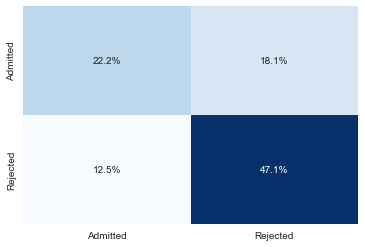

In [22]:
# Implementamos un mapa de calor definiendo las clases
sns.heatmap(cnf, xticklabels=target_label, yticklabels=target_label,
                # generamos las anotaciones en términos porcentuales
                annot=True, fmt=".1%",
                # evitamos la barra y cambiamos el colormap
                cbar=False, cmap='Blues');


Nuestro modelo clasifica de forma correcta aproximadamente el 70% de los casos como
positivos o negativos. El modelo tiende a desempeñarse de peor manera para predecir los
casos aceptados, en comparación a los casos rechazados.

Otra manera de observar esto es mediante la obtención de métricas de desempeño como el
classification_report, que entrega la precisión (Porcentaje de identificaciones positivas
correctas por sobre el total de predicciones como positivas), el recall (Porcentaje de
identificaciones positivas por sobre el total de predicciones correctas) y el F1 (Media
armónica entre Precision y Recall).


In [23]:
# generar un reporte de métricas de precisión, recall y f1
print(classification_report(y_test_vec, y_hat))

              precision    recall  f1-score   support

           0       0.64      0.55      0.59       548
           1       0.72      0.79      0.75       810

    accuracy                           0.69      1358
   macro avg       0.68      0.67      0.67      1358
weighted avg       0.69      0.69      0.69      1358



Las métricas reportadas apoyan el diagnóstico realizado con la matriz de confusión. El
modelo tiene un mejor desempeño para predecir correctamente los rechazados por sobre
los aceptados. Las métricas tienen valores más altos para los casos clasificados como
rechazados. Para todas las métricas, los puntajes son mayores que en comparación al
promedio global de la muestra.

#### Digresión: Métricas de Desempeño en problemas de clasificación

Ya tenemos conocimiento sobre la variante más simple para evaluar un problema de
clasificación: La exactitud (Accuracy) promedio del modelo. Estrictamente, la exactitud
informa sobre la cantidad de clases positivas y negativas correctamente identificadas. Uno
de los problemas asociados a la exactitud es que no funciona de manera adecuada cuando
nuestras clases son desbalanceadas.

También tenemos conocimiento sobre la matriz de confusión, la frecuencia entre lo predicho
y lo observado para cada una de las clases. Resulta que por lo general procesaremos esta
matriz de confusión para obtener una serie de métricas más informativas:

- La primera es la precisión (Precision) del modelo: Busca medir la exactitud de las
predicciones sólo en las clases positivas. De esta manera, si estamos interesados en
identificar sólo una clase e ignorar el desempeño del modelo en las demás clases,
estaremos interesados en tener buenas métricas de precisión.
- Por lo general la precisión del modelo suele acompañarse con la métrica de memoria
(Recall): busca medir la exactitud de las predicciones positivas identificadas
correctamente por sobre la cantidad de casos relevantes.

- Ambas métricas se pueden promediar en el puntaje F1, que ajusta la relación entre Precision y Recall.

Por último, siempre es bueno graficar el rango de errores con el cual opera nuestro modelo.
Para ello implementamos la curva ROC (Receiving Operating Characteristics), que evalúa la
relación entre falsos positivos (cuando el modelo etiqueta erróneamente) y falsos negativos
(cuando el modelo ignora etiquetas). También solicitaremos el área bajo la curva ROC.
Para implementarlo ocupamos los métodos roc_curve y roc_auc_score del módulo
metrics de la librería sklearn.


In [24]:
# para implementar el área bajo la curva necesitamos el puntaje
# de probabilidad, no la clase predicha. Para ello implementamos predict_proba
y_hat_pr = nb_classifier.predict_proba(X_test_mat)[:,1]
# el método roc_curve devuelve 3 elementos: falsos positivos, verdaderos positivos,
# y threshold. Este último lo podemos ignorar con _
fpr, tpr, _ = roc_curve(y_test_vec, y_hat_pr)
# podemos obtener el área bajo la curva roc con roc_auc_score
auc = round(roc_auc_score(y_test_vec, y_hat_pr), 3)


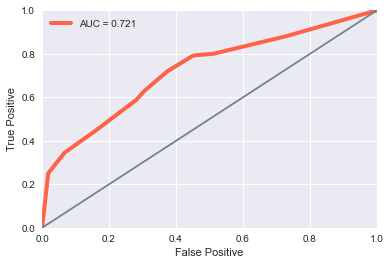

In [25]:
# graficamos
plt.plot(fpr, tpr, label="AUC = {}".format(auc), color='tomato', lw=4)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.axis([0, 1, 0, 1])
# graficamos el clasificador por chance.
plt.plot([0, 1], [0, 1], color='slategrey')
plt.legend();

Para evaluar la idoneidad de nuestro modelo y su capacidad predictiva, necesitamos generar
un benchmark analítico, que generalmente se traduce en un clasificador correcto por
chance. Éste toma la forma matemática de 1/𝑌.

En este caso estamos trabajando con dos clases, por lo que la probabilidad de tener una
clasificación correcta dado que la etiquetamos al azar es del 50%. Nuestros modelos deben
superar este benchmark para considerarlos eficientes. En este caso, nuestro modelo tiene
un desempeño un 20% superior a clasificar correctamente al azar una observación.


### Efecto de la probabilidad a priori en el modelo
Un aspecto a considerar en el algoritmo NB (y de manera más general en el marco analítico
Bayesiano), es la ventaja de poder ingresar información previa sobre cómo se comportan
nuestras clases. Esta información conocida como probabilidad a priori, interactúa con la
verosimilitud del evento para actualizarlo en función del comportamiento pasado.

Por defecto, BernoulliNB infiere las clases a priori a partir de la frecuencia empírica de
ocurrencia de estas. Una vez inicializado nuestro modelo podemos ingresar al logaritmo de
la probabilidad con BernoulliNB().class_log_prior_. Exponenciando este array
obtenemos la probabilidad a priori de la ocurrencia de cada clase.


In [26]:
np.exp(nb_classifier.class_log_prior_).round(2)

array([0.38, 0.62])

Podemos asegurarnos que el modelo aprenderá la información a priori a partir de la
frecuencia de ocurrencia del vector objetivo, de manera tal de no intervenir el modelo. Si
solicitamos el value counts de nuestro vector objetivo antes de ser segmentado
obtendremos resultados similares.

In [27]:
df_deagg['Admit'].value_counts('%').round(2)

1    0.61
0    0.39
Name: Admit, dtype: float64

Ahora generamos un experimento donde someteremos nuestro algoritmo clasificador a
distintas especificaciones sobre la ocurrencia previa de las clases. En la función
compare_priors comparamos las métricas Accuracy, Recall, Precision, F1 y AUC para las
siguientes especificaciones, dado los priors y las muestras de entrenamiento y validación:

#### Caso 1: a priori no informativo
En este caso las métricas son idénticas a las reportadas en el modelo, puesto que por
defecto infiere la frecuencia de cada clase.

In [28]:
gfx.compare_priors(X_train=X_train_mat, X_test=X_test_mat, y_train=y_train_vec, y_test=y_test_vec, prior=[0.39, 0.61])

A priori: [0.39, 0.61]
Accuracy: 0.694
Recall: 0.79
Precision: 0.722
F1: 0.755
AUC: 0.721



#### Caso 2: A priori, clases extremadamente balanceadas
Al asumir que ambas clases tienen iguales chances de ocurrir. En este escenario hay un
empeoramiento general del modelo, ya que hay una disminución en el desempeño de las
métricas. El modelo asume en base a la información previa que como antes habían más
postulantes aceptados y menos rechazados, la verosimilitud tiende a incorporar ésta
información conllevando a una pérdida en la tasa general de clasificaciones correctas
(Accuracy).

In [29]:
gfx.compare_priors(X_train=X_train_mat, X_test=X_test_mat, y_train=y_train_vec, y_test=y_test_vec, prior=[.5, .5])

A priori: [0.5, 0.5]
Accuracy: 0.694
Recall: 0.79
Precision: 0.722
F1: 0.755
AUC: 0.721



#### Caso 3: Clases desbalanceadas. 4 de 5 entran
En este caso se encuentra una mayor precisión en el modelo, lo que significa que identifica
bien quienes están clasificados como rechazados entre los correctamente clasificados. Esto
se debe a que estamos aumentando de manera sustancial el efecto de la información a
priori en los aceptados.


In [30]:
gfx.compare_priors(X_train=X_train_mat, X_test=X_test_mat, y_train=y_train_vec, y_test=y_test_vec, prior=[.8, .2])

A priori: [0.8, 0.2]
Accuracy: 0.546
Recall: 0.251
Precision: 0.953
F1: 0.397
AUC: 0.721



#### Caso 4: Berkeley en el 2015
Podemos actualizar nuestro algoritmo para ver cómo se comportarían ésta muestra en base
a los últimos datos disponibles sobre las tasas de aceptación. La información disponible en
el sitio web de Berkeley sugiere que aproximadamente un 17% de los postulantes son
aceptados, con un 83% rechazados. ¿Cómo se comportaría nuestra predicción en base a
esta información?
Resulta que al implementar priors correspondientes al 2015, nuestro modelo mejora en su
puntaje F1, así como en el Recall, por lo que nuestro modelo mejora en la capacidad de
predecir correctamente tanto positivos como negativos.

In [31]:
gfx.compare_priors(X_train=X_train_mat, X_test=X_test_mat, y_train=y_train_vec, y_test=y_test_vec, prior=[.17, .83])

A priori: [0.17, 0.83]
Accuracy: 0.635
Recall: 0.881
Precision: 0.641
F1: 0.742
AUC: 0.721

